# 引言
    残差神经网络(ResNet)是由微软研究院的何恺明、张祥雨、任少卿、孙剑等人提出的。ResNet 在2015 年的ILSVRC（ImageNet Large Scale Visual Recognition Challenge）中取得了冠军。残差神经网络的主要贡献是发现了“退化现象（Degradation）”，并针对退化现象发明了 “快捷连接（Shortcut connection）”，极大的消除了深度过大的神经网络训练困难问题。神经网络的“深度”首次突破了100层、最大的神经网络甚至超过了1000层。

# 什么是ResNet？
    ResNet是一种残差网络（由许多残差块组成），可以理解为一个子网络，这个子网络经过堆叠构成一个很深的网络。
<img src="pic\26.jpg" width="500"/>

在2012年的ILSVRC挑战赛中，AlexNet取得了冠军，并且大幅度领先于第二名。由此引发了对AlexNet广泛研究，并让大家树立了一个信念——“越深网络准确率越高”。这个信念随着VGGNet、Inception v1、Inception v2、Inception v3不断验证、不断强化，得到越来越多的认可，但是，始终有一个问题无法回避，这个信念正确吗？

# 为什么引入ResNet？

通过实验，ResNet随着网络层不断的加深，模型的准确率先是不断的提高，达到最大值（准确率饱和），然后随着网络深度的继续增加，模型准确率毫无征兆的出现大幅度的降低。

<img src="pic\27.jpg" width="300"/>

<img src="pic\29.jpg" width="500" />

如果一个模型够简单，那么可能值需要F1范围的东西。往往我们可以加更多层（到F6），使得模型能够学习到更大的东西。如上图，F3模型到目标的距离比F6模型更小，虽然F6的模型更加的复杂，但是实际上可能学偏了，这就是模型偏差。

## 那应该如何解决这个问题呢？（核心思想）
* 在每个模型中包含前面的模型，如图下侧所示
## 残差块

<img src="pic\30.jpg" width="500"/>

ResNet沿用了VGG完整3x3的卷积层设计。 

残差块里首先有2个有相同输出通道数3x3的卷积层。 

每个卷积层后接一个批量规范化层和ReLU激活函数。 

然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。

 **这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加**。 如果想改变通道数，就需要引入一个额外1x1的卷积层来将输入变换成需要的形状后再做相加运算


In [2]:
import torch
import torch
from torchvision import transforms
from  torch.utils import data 
import torchvision
import matplotlib.pyplot as plt

In [3]:
class Resnet(torch.nn.Module):
    '''输入通道和输出通道相同，才能保证和输入数据相加'''
    def __init__(self,input_channels,num_channels,
                    use_1conv=False,stride=1):
        super().__init__()
        self.conv1=torch.nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=stride)
        self.conv2=torch.nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
        #如果向改变通道数，使用1X1的卷积层来变换通道数
        if use_1conv:  
            self.conv3=torch.nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=stride)
        else:
            self.conv3=None
        #批量规范化  防止梯度爆炸或者消失
        self.bn1=torch.nn.BatchNorm2d(num_channels)
        self.bn2=torch.nn.BatchNorm2d(num_channels)
        #激活函数
        self.relu=torch.nn.ReLU(inplace=True)

    def forward(self,x):
        y=self.relu(self.bn1(self.conv1(x)))
        y=self.bn2(self.conv2(y))
        if self.conv3:
            x=self.conv3(x)
        y+=x  #数据相加s
        #y=self.relu(y)  #<-----------------------
        return self.relu(y)

blk=Resnet(3,3)
x=torch.rand(4,3,6,6)
y=blk.forward(x)
print("input_shape:",x.shape)
print("output_shape:",y.shape)

input_shape: torch.Size([4, 3, 6, 6])
output_shape: torch.Size([4, 3, 6, 6])


In [4]:
# 增加通道数
blk=Resnet(3,6,use_1conv=True,stride=2)
x=torch.rand(4,3,6,6)
print("input_shape:",x.shape)
y=blk.forward(x)
print("output_shape:",y.shape)

input_shape: torch.Size([4, 3, 6, 6])
output_shape: torch.Size([4, 6, 3, 3])


此代码生成两种类型的网络： 一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。 另一种是当use_1x1conv=True时，添加通过1x1卷积调整通道和分辨率。

<img src="pic\31.jpg" width="500"/>

## ResNet模型
    ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的7x7卷积层后，接步幅为2的的3x3最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层


In [5]:
#第一层卷积层
b1=torch.nn.Sequential(
    torch.nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    torch.nn.BatchNorm2d(64),  #防止梯度爆炸或者消失
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [6]:
'''
input_channels:输入通道
num_channels:输出通道
num_resuduals:每个残差块的卷积层数量
'''
def resnet_block(input_channels,num_channels,num_resuduals,first_blk=False):
    blk=[]
    for i in range(num_resuduals):
        #对第一个残差块的第一个块进行特殊处理（改变x的通道数，和输出相加）
        if i==0 and not first_blk:
            blk.append(Resnet(input_channels,num_channels,
                                use_1conv=True,stride=2))
        else:
            blk.append(Resnet(num_channels,num_channels))
    return blk


In [7]:
def ResNet():
    #第一层卷积层
    b1=torch.nn.Sequential(
        torch.nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
        torch.nn.BatchNorm2d(64),  #防止梯度爆炸或者消失
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )
     #一个残差块不需要调整通道数
    b2 = torch.nn.Sequential(*resnet_block(64, 64, 2, first_blk=True)) 
    b3 = torch.nn.Sequential(*resnet_block(64, 128, 2))
    b4 = torch.nn.Sequential(*resnet_block(128, 256, 2))
    b5 = torch.nn.Sequential(*resnet_block(256, 512, 2))
    net=torch.nn.Sequential(
        b1,b2,b3,b4,b5,
        torch.nn.AdaptiveAvgPool2d((1,1)),
        torch.nn.Flatten(),
        torch.nn.Linear(512,10)
    )
    return net

每个模块有4个卷积层（不包括恒等映射1x1的卷积层）。 加上第一个7x7卷积层和最后一个全连接层，共有18层。 因此，这种模型通常被称为ResNet-18。 通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。 虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。 图7.6.4描述了完整的ResNet-18。

<img src="pic\32.jpg" width="200"/>  
<img src="pic\33.jpg" width="200"/>




In [8]:
net=ResNet()
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Resnet(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Resnet(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

## 读取数据

In [9]:
def load_data(batch_size,resize):
    # 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
    # 并除以255使得所有像素的数值均在0到1之间
    trans =[transforms.ToTensor()]
    #修改图片大小
    if resize:
        trans.insert(0,transforms.Resize(resize)) 
    trans=transforms.Compose(trans)
    #下载训练数据
    mnist_train = torchvision.datasets.FashionMNIST(
        root="datasets",  #保存的目录
        train=True,       #下载的是训练数据集
        transform=trans,   #得到的是pytorch的tensor，而不是图片
        download=True)  #从网上下载
    print(type(mnist_train))    
    #下载测试数据
    mnist_test = torchvision.datasets.FashionMNIST(
        root="datasets", train=False, transform=trans, download=True)
    print(mnist_train)
    print(len(mnist_train),len(mnist_test))
    #装载数据
    data_loader_train=data.DataLoader(dataset=mnist_train,
                                                batch_size=batch_size,
                                                shuffle=True)   #数据是否打乱
    data_loader_test=data.DataLoader(dataset=mnist_test,
                                    batch_size=batch_size,
                                    shuffle=True)
    return data_loader_train,data_loader_test

## 训练模型
* wxw：输入图片的大小
* fxf：卷积核大小
* s：步长（stride）
* p：padding
### 卷积层后的输出大小公式
* 计算公式：N=(w-f+2p)/s+1**小数向上取整**

### 池化层的输出大小公式
* N'=(N-f)/s+1 **小数向上取整**

In [10]:
'''定义预测准确率函数'''
def acc(y_hat,y):
    '''
    :param y_hat: 接收二维张量，例如 torch.tensor([[1], [0]...])
    :param y: 接收二维张量，例如 torch.tensor([[0.1, 0.2, 0.7], [0.8, 0.1, 0.1]...]) 三分类问题
    :return:
    '''
    y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y  #数据类型是否相同
    return float(cmp.type(y.dtype).sum())
    
class Accumulator():
    ''' 对评估的正确数量和总数进行累加 '''
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, item):
        return self.data[item]

'''自定义每个批次训练函数'''
def train_epoch(net,train_iter,loss,optimizer,device):
    #判断是不是pytorch得model，如果是，就打开训练模式，pytorch得训练模式默认开启梯度更新
    if isinstance(net,torch.nn.Module):
        net.train()
    #创建样本累加器【累加每批次的损失值、样本预测正确的个数、样本总数】
    metric = Accumulator(3)  
    for x,y in train_iter:
        x=x.to(device)                            #<----------------------GPU
        y=y.to(device)
        #前向传播获取预测结果
        y_hat=net(x)
        #计算损失
        l=loss(y_hat,y) 
        #判断是pytorch自带得方法还是我们手写得方法（根据不同得方法有不同得处理方式）
        if isinstance(optimizer,torch.optim.Optimizer):
            #梯度清零
            optimizer.zero_grad()
            #损失之求和，反向传播（pytorch自动进行了损失值计算）
            l.backward()
            #更新梯度
            optimizer.step()
            #累加个参数
            metric.add(
                float(l)*len(y),  #损失值总数
                acc(y_hat,y),     #计算预测正确得总数
                y.size().numel()  #样本总数
            )
    #返回平均损失值，预测正确得概率
    return metric[0]/metric[2],metric[1]/metric[2]

'''模型测试'''
def test_epoch(net,test_iter,device):
    if isinstance(net,torch.nn.Module):
        net.eval()  #将模型设置为评估模式
    metric=Accumulator(2)
    for x,y in test_iter:
        x=x.to(device)                            #<----------------------GPU
        y=y.to(device)
        metric.add(
            acc(net.forward(x),y),  #计算准确个数
            y.numel()  #测试样本总数
        )
    return metric[0]/metric[1]

'''正式训练'''
def train_LeNet(num_epochs,trian_iter,test_iter,lr):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    net=ResNet()  #VGG网络
    net=net.to(device)  #将网络放在gpu或cpu运行<--------------
    loss_list=[]
    train_acc=[]
    test_acc=[]
    #初始化权重
    def init_weight(m):
        if type(m)==torch.nn.Linear or type(m)==torch.nn.Conv2d:
            torch.nn.init.xavier_normal_(m.weight)
    net.apply(init_weight)
    #损失函数
    loss=torch.nn.CrossEntropyLoss()
    #优化器
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    #训练
    for epoch in range(num_epochs):
        #返回平均损失值和正确率
        train_metrics=train_epoch(net,trian_iter,loss,optimizer,device)  #<-----训练
        loss_list.append(train_metrics[0])  #保存loss
        train_acc.append(train_metrics[1])   #保存准确率
        #测试集
        test_metric=test_epoch(net,test_iter,device)     #<-------------测试
        test_acc.append(test_metric)
        print(f"epoch{epoch+1}:loss={train_metrics[0]},train_acc={train_metrics[1]*100:.2f}%,test_acc={test_metric*100:.2f}%")
    
    return loss_list,train_acc,test_acc

'''可视化'''
def draw(num_epochs,loss_list,train_acc,test_acc):
    fig,ax=plt.subplots()   #定义画布
    ax.grid(True)          #添加网格
    ax.set_xlabel("epoch")
    #ax.set_ylim(0,1)

    ax.plot(range(num_epochs),loss_list,label="loss")
    ax.plot(range(num_epochs),train_acc,dashes=[6, 2],label="train")
    ax.plot(range(num_epochs),test_acc,dashes=[6, 2],label="test")
    ax.legend(title="ResNet")
    ax.legend()
    plt.show()

In [11]:
batch_size=64
num_epochs=10
lr=0.01
#查看网络参数
x=torch.randn(size=(1,1,224,224))
for blk in ResNet():
    x=blk(x)
    print(blk.__class__.__name__,'output shape:\t',x.shape)
#数据集
train_iter,test_iter=load_data(batch_size=64,resize=224)
#训练
loss_list,train_acc,test_acc=train_LeNet(num_epochs,train_iter,test_iter,lr)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])
<class 'torchvision.datasets.mnist.FashionMNIST'>
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
60000 10000
cuda


KeyboardInterrupt: 

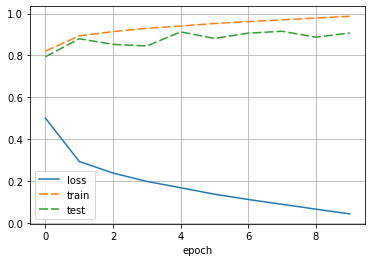

: 

In [ ]:
draw(num_epochs,loss_list,train_acc,test_acc)

# 小结
* 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
* 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。
* 加快收敛的速度
* 防止梯度爆炸或者消失